# CLIMADA & OpenStreetMap

CLIMADA provides some ways to make use of the entire [OpenStreetMap data](https://www.openstreetmap.org/) and to use those data within the risk modelling chain of CLIMADA as exposures. This tutorial will walk you through how to get any OSM data into tabular format, and how to perform impact / risk computations on this data.

Recommended reading for OSM and risk assessments: 
*Mühlhofer, Kropf, Riedel, Bresch and Koks (under rev.): OpenStreetMap for Multi-Faceted Climate Risk Assessments. Environmental Research Communications. doi: [10.31223/X5SQ2J](https://eartharxiv.org/repository/view/5615/)*

## Part 0: Introduction & Overview on OSM data

 **Which methods exist for getting data and which one is right for my query?**
 
OSM data can be obtained in geodataframe format along two pathways
  
_Option 1_: first download _all_ map raw data witin a certain geographic area that is on OSM, in the OSM-specific data format (osm.pbf). Then, an SQL query extracts only the info that is wanted and loads it into memory. One may either downnload country files (from a daily-updated provider, Geofabrik.de), or a larger region or even the entire planet file once, and then clip sub-files with raw data for any desired custom-made region from these larger parent file. The query/extraction process afterwards is the same.
  
_Option 2_: Directly and selectively download the desired info from the overpass-turbo API, without downloading the complete raw data dumps beforehand. This is however heavily constrained in terms of download quota and requires stable internet connection for each download process.

 The first option of downloading data dumps and then parsing from them is implemented in the external package `osm-flex`, which is installed within the CLIMADA coding environment. The second option is implemented within CLIMADA, as `OSMApiQuery` - methods in the `Exposures.osm_dataloader` module.

**A few words on the OSM data world, OSM overpass-turbo, Overpass QL & OSM data structures (nodes, ways, relations)**

**OSM tags, key-value pairs, and quick overview on "what's out there"** Check out https://taginfo.openstreetmap.org/ for finding the key-value pairs ("tags") you're looking for. You will need to know this for specifying your query (at least in the API-pathway).
Check out https://overpass-turbo.eu/ for a fast visual overview on results that your query will yield.

**The OSM API (overpass)**: The OSM API has constraints on how much can be downloaded at once (reached quite fast, especially around mid-day / early afternoon..). This is why providers (such as [Geofabrik](https://www.geofabrik.de/)) exist that generate data daily data dumps of all the OSM data that exists. For the API downloading strategy, wait-times are implemented in the querying, but re-consider your strategy if you run into a time-out error. Overpass Query language, which is needed to query directly from the OSM API can be a bit cryptic. The majority of what you will need is transformed in the `OSMApiQuery` class automatically.
For more, check out the detailed read-the-docs: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL 

**OSM data structures:** Elements are the basic components of OpenStreetMap's conceptual data model of the physical world. Elements are of three types:

* nodes (defining points in space),
* ways (defining linear features and area boundaries), and
* relations (which are sometimes used to explain how other elements work together).

Check out https://wiki.openstreetmap.org/wiki/Elements for more info.

## Part 1: Downloading, clipping and parsing OSM data

### 1.1:  Getting OSM data from OSM data dumps (*osm.pbf files)

In this example, we download the data dump for a country (Honduras) from Geofabrik. In the second step, specific info can be extracted (parsed) from the raw files into tabular format. 

**NOTE:** This is only a minimal example, as downloading, clipping and parsing is performed with the `osm-flex` package, which has extensive documentation that can be found [here](https://osm-flex.readthedocs.io/en/latest/index.html). 

In [17]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
import os

import osm_flex
import osm_flex.download
import osm_flex.extract
import osm_flex.clip
import osm_flex.simplify

from climada import CONFIG
osm_flex.enable_logs()


**Download**  a raw osm.pbf file ("data dump") for Honduras from geofabrik.de 

In [4]:
# (checks if file honduras-latest.osm.pbf already exists)
# file is stored as defined in osm_flex.config.OSM_DATA_DIR unless specified otherwise
iso3 = 'HND'
path_hnd_dump = osm_flex.download.get_country_geofabrik(iso3)

INFO:osm_flex.download:Skip existing file: /Users/evelynm/osm/osm_bpf/honduras-latest.osm.pbf


**Extracting pre-written query classes from the data dump**

Extracting critical infrastructure with pre-written queries:
For critical infrastructure, a set of wrappers exist that parse all data belonging to this sector. 

In [5]:
# check available critical infrastructure types:
osm_flex.config.DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [6]:
# lets extract all roads from the Honduras file, via the wrapper
gdf_roads_hnd = osm_flex.extract.extract_cis(
    path_hnd_dump,
    'road')

INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 0it [00:00, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]
INFO:osm_flex.extract:query is finished, lets start the loop
extract lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 112215/112215 [00:07<00:00, 14463.46it/s]


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_4655/3520574044.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


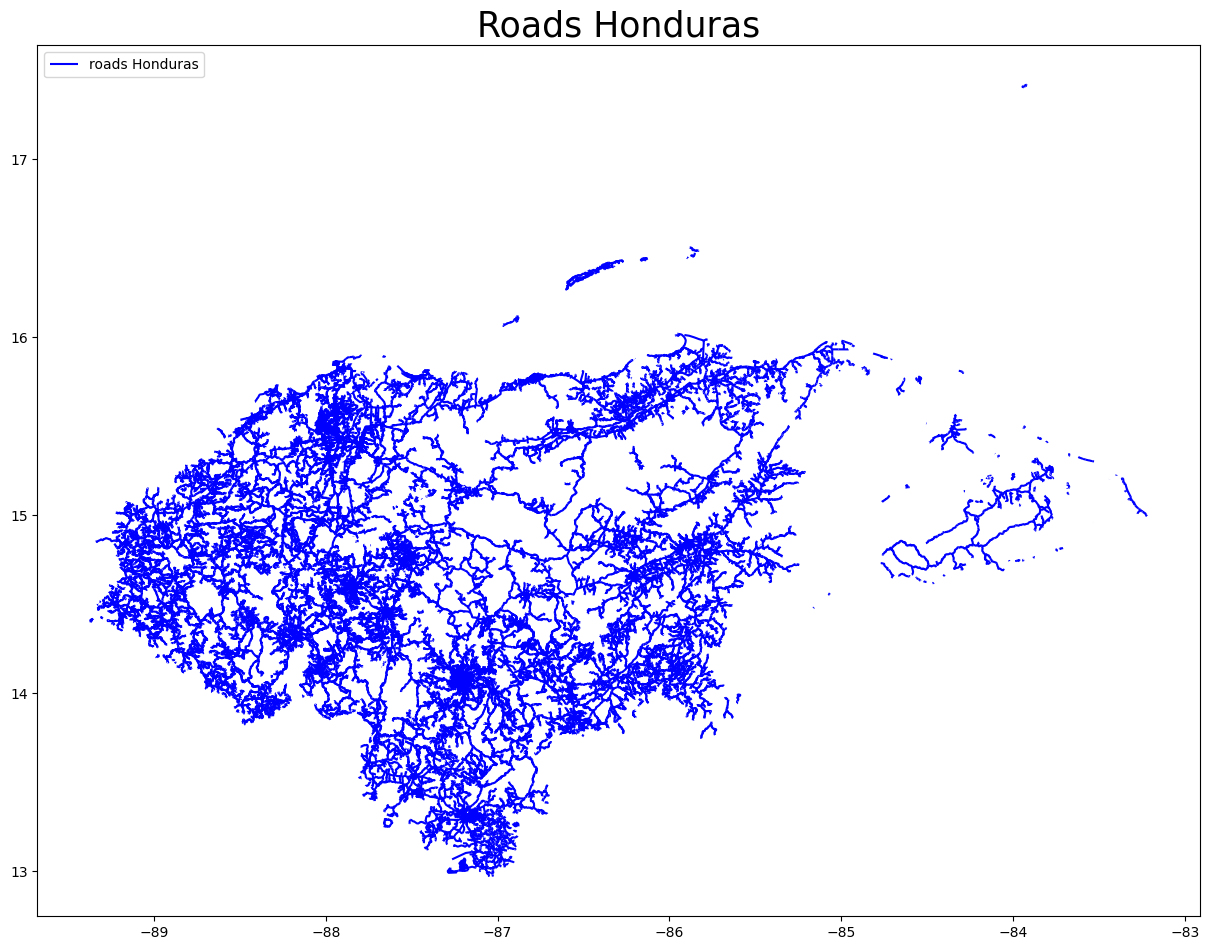

In [10]:
# plot results
ax = gdf_roads_hnd.plot(figsize=(15, 15), alpha=1, markersize=5, color='blue',
                    edgecolor='blue', label='roads Honduras')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Roads Honduras', fontsize=25)
plt.show()

**Extracting any custom-made query from the data dump**

Any other tags that are available on openstreetmap can also be queried with the `extract()` method.
Two variables have to be specified: `osm_keys`, a list with all the columns to report in the gdf, and `osm_query`, a string of key-value constraints to apply during the search.

In [8]:
# Forests (multipolygons) in Honduras
osm_keys = ['landuse']
osm_query = "landuse='forest'"
gdf_forest = osm_flex.extract.extract(path_hnd_dump, 'multipolygons', osm_keys, osm_query)

INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 709/709 [00:04<00:00, 144.00it/s]


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_4655/3095862923.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


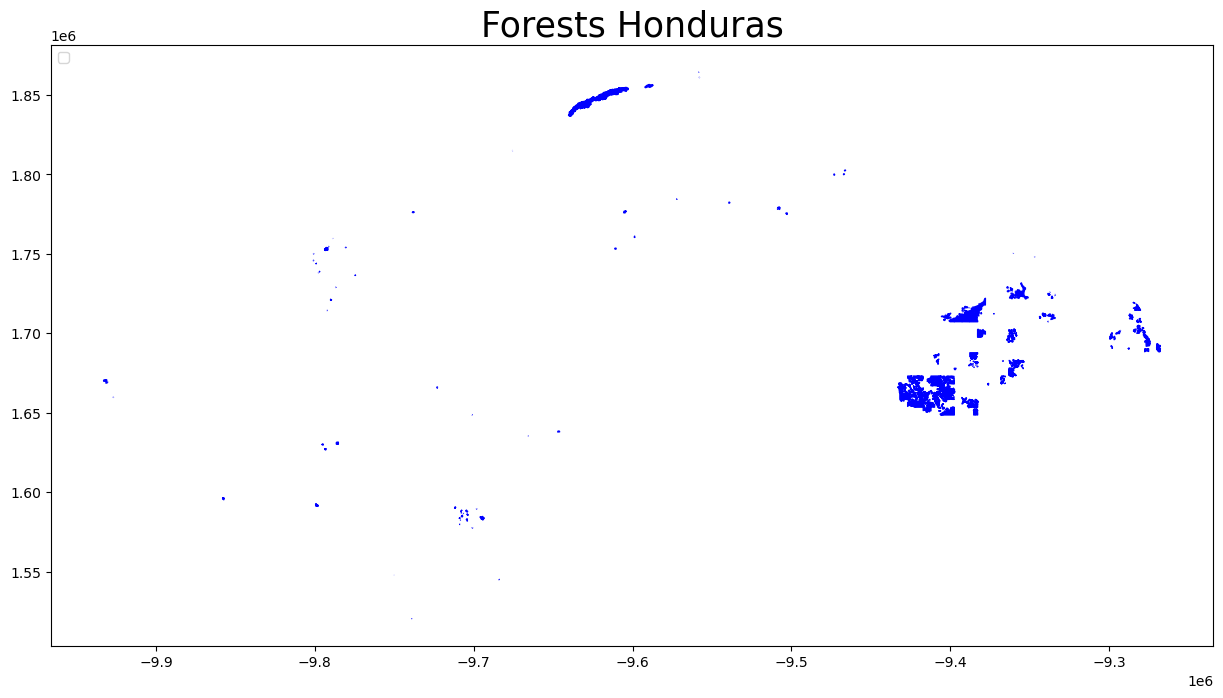

In [11]:
# Plot results
ax = gdf_forest.to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue',
                    edgecolor='blue', label='forests HND')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Forests Honduras', fontsize=25)
plt.show()

**Extracting data from a custom-clipped data dump**

Instead of retrieving all the applicable data within a country raw data file, we can cut out (=clip) any desired shape or bounding box from the entire planet file (has to be downloaded first once, ca. 60 GB) or from a regional file (such as Europe, North America, etc.), and then perform an extraction on this sub-file.

To clip shapes from the planet.osm.pbf file, `osm-flex` uses one of teh command line tools `osmosis` or `osmconvert` under the hood. Both need to be manually installed:

Osmosis (works for Windows, Linux and Mac) needs to be installed as explained here: https://wiki.openstreetmap.org/wiki/Osmosis/Installation. You may also need to install Java.

Osmconvert (works for Windows, Linux and Mac) needs to be installed as explained here: https://wiki.openstreetmap.org/wiki/osmconvert. For Mac, installation instructions may not be satisfactory. Alternatively, it may work running the command line command `brew install osmfilter`, which includes osmconvert.

There are currently three implemented ways to clip desired shapes:
* By indicating a bounding box passed as lists ([xmin, ymin, xmax, ymax]) --> `clip_from_bbox()`
* By providing a path to a .poly file which contains the outline of the shape to be cut out. --> `clip_from_poly()`
* By providing a list of shapes (polygons, multipolygons), which represent the outline of the shape to be cut out. This method also creates and saves a corresponding .poly file in the background, which is then passed to osmosis / osmconvert. --> `clip_from_shapes()`

**Note** Takes quite a while to cut out certain parts (up to an hour..) The cutting process is sped up if the parent file is smaller (e.g. a regional osm.pbf file instead of the entire planet file).

**Note** A description of the file format of .poly files, with certain aspects to consider, can be found here:  https://wiki.openstreetmap.org/wiki/Osmosis/Polygon_Filter_File_Format . A routine to convert shapes at admin3 to admin1 level for any country in the world into poly files can be found here: https://github.com/ElcoK/osm_clipper. 

**Note** Anti-meridian crossings (along the 180° latitude line) cause issues. Polygons have to be split along this line and passed separately (within the same list, or in the same .poly file is ok). For detecting and splitting those cases, see the following article with linked code on GitHub: https://towardsdatascience.com/around-the-world-in-80-lines-crossing-the-antimeridian-with-python-and-shapely-c87c9b6e1513 

**Example: Clip data within a bounding box**

In [21]:
# Define a bbox around roughly Honduras, San Salvador & Nicaragua
bbox_customreg = [-90.043806, 10.939216, -83.116254, 15.956278]

# load the central-america parent file from which we want to clip
path_ca_dump = osm_flex.download.get_region_geofabrik('central-america')
# new save path
path_custom_dump = os.path.join(osm_flex.config.OSM_DATA_DIR, 'custom_region.osm.pbf')

# perform clipping with command line tool osmosis (other option: osmconvert)
osm_flex.clip.clip_from_bbox(
    bbox_customreg,
    path_ca_dump,
    path_custom_dump,
    kernel='osmosis')

INFO:osm_flex.download:Skip existing file: /Users/evelynm/osm/osm_bpf/central-america-latest.osm.pbf
INFO:osm_flex.clip:File doesn`t yet exist or overwriting old one.
                    Assembling osmosis command.
INFO:osm_flex.clip:Extracting from larger file...
                    This will take a while
Nov 24, 2023 4:22:44 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.48.3
Nov 24, 2023 4:22:44 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
Nov 24, 2023 4:22:44 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Launching pipeline execution.
Nov 24, 2023 4:22:44 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline executing, waiting for completion.
Nov 24, 2023 4:23:34 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline complete.
Nov 24, 2023 4:23:34 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Total execution time: 50140 milliseconds.


Now we can repeat a similar query (e.g. road data) for our newly cut-out data region.

In [23]:
# lets extract all roads from the Honduras file, via the wrapper
gdf_roads_customreg = osm_flex.extract.extract_cis(path_custom_dump, 'road')

INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 0it [00:00, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.58s/it]
INFO:osm_flex.extract:query is finished, lets start the loop
extract lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 272481/272481 [00:19<00:00, 14078.86it/s]


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_4655/3326432630.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


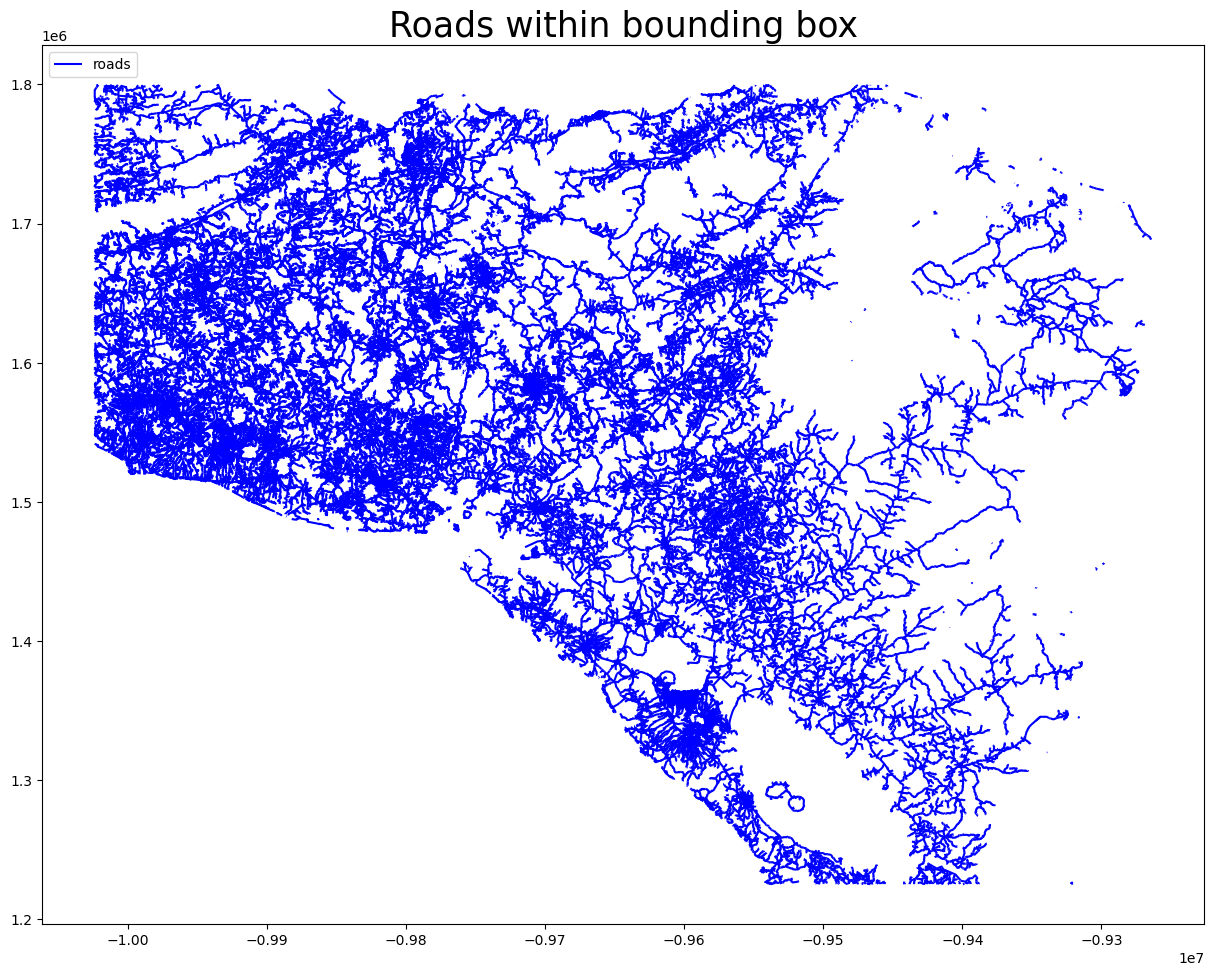

In [25]:
# plot results
ax = gdf_roads_customreg.to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue',
                    edgecolor='blue', label='roads')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Roads within bounding box', fontsize=25)
plt.show()

**Clip data within a custom (multi-)polygon**
See the tutorial provided by osm-flex.

### 1.2: Download data from the overpass-API

At the moment, the `OSMApiQuery` class accepts both an _area_ and a _query condition_ as inputs.

Area can be a bounding box (xmin, ymin, xmax, ymax) or a polygon.
The query conditions must be a string in the format `'["key"]'` or `'["key"="value"]'`, etc. For more query syntaxes, have a look at the [OverpassQL page](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL).

####  Example: Buildings & Churches in the city of Zurich

In [2]:
# reload required modules
import shapely
from climada_petals.entity.exposures.osm_dataloader import OSMApiQuery
from climada import CONFIG

DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()

In [4]:
# Two area-formats that are accepted: a bounding box tuple or list (xmin, ymin, xmax, ymax) and polygons
area_bbox = (8.5327506, 47.368260, 8.5486078, 47.376877)
area_poly = shapely.geometry.Polygon([(8.5327506, 47.368260), (8.5486078, 47.376877), (8.5486078, 47.39)])

# Two examples for query conditions:
condition_church = '["amenity"="place_of_worship"]'
condition_building = '["building"]'

# Initialize OSMApiQuery instances
zrh_churchquery_bbox = OSMApiQuery.from_bounding_box(area_bbox, condition_church)
zrh_buildingquery_poly = OSMApiQuery.from_polygon(area_poly, condition_building)

After instantiating the queries with an area and a query condition, the data can now be downloaded from the overpass-API. Depending on the time of the day and the size of the query, this can lead to overloads.

The following request should be small enough that it always works:

In [5]:
gdf_zrh_churches = zrh_churchquery_bbox.get_data_overpass()

In [6]:
gdf_zrh_buildings = zrh_buildingquery_poly.get_data_overpass()

2023-12-07 13:31:50,483 - climada_petals.entity.exposures.osm_dataloader - INFO - Empty geometry encountered.


Let's have look at our downloaded data. The downloaded data is assembled into a geodataframe with an `osm_id` column and a `tags` columns. The latter reports all the tags associated with the respective result.

In [7]:
gdf_zrh_churches.head()

,osm_id,geometry,tags
0,24701951,"POLYGON ((8.54050 47.37097, 8.54058 47.37098, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
1,33854803,"POLYGON ((8.54552 47.37404, 8.54552 47.37404, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
2,36916418,"POLYGON ((8.54413 47.37017, 8.54405 47.37021, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
3,40478435,"POLYGON ((8.54656 47.37475, 8.54628 47.37464, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
4,80338523,"POLYGON ((8.53520 47.37333, 8.53494 47.37345, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."


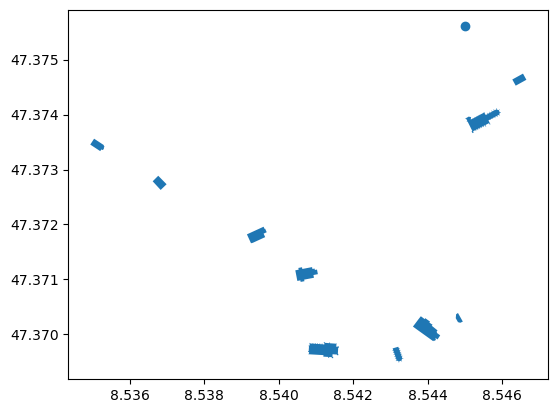

In [8]:
gdf_zrh_churches.plot();

In [30]:
gdf_zrh_buildings.head()

,osm_id,geometry,tags
0,4633,"POLYGON ((8.54832 47.37961, 8.54831 47.37936, ...","{'addr:city': 'Zürich', 'addr:housename': 'ETH..."
1,7565,GEOMETRYCOLLECTION EMPTY,"{'building': 'public', 'building:levels': '6',..."
2,405794,"POLYGON ((8.54124 47.37587, 8.54119 47.37583, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
3,4235320,"POLYGON ((8.54372 47.37844, 8.54377 47.37804, ...","{'building': 'office', 'type': 'multipolygon'}"
4,4281153,"POLYGON ((8.53952 47.37959, 8.53952 47.37960, ...","{'addr:housenumber': '2', 'addr:street': 'Muse..."


<Axes: >

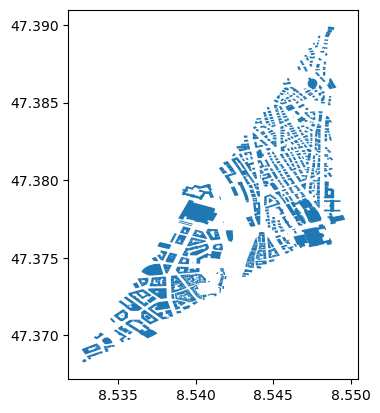

In [31]:
gdf_zrh_buildings.plot()

## Part 2: Risk computation with OSM data as CLIMADA Exposures

Having obtained GeoDataFrame(s) with OSM data in part 1, the following steps for impact calculations will be analogous to any impact calculations on Exposures with point, polygon and / or line geometries.
The tutorial in [climada_python/doc/tutorial/entity_exposures_lines_polygons](https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/climada_entity_Exposures_polygons_lines.ipynb) gives detailed info on how to generally handle those types within CLIMADA exposures.

For completeness, only a short demo will be given here using OSM data.

### 2.1: Setting up a high-res CLIMADA exposure from scratch with point, line & polygon data from OSM

The general steps are the following to create exposures from line or polygon data from OSM: 

   1. Lines / Polygons to points: Specify a distance into which lines are split, or an area into which polygons are split, to get an interpolated gdf. 

   2. Valuation: Indicate a value per meter or m2, or use LitPop asset values to re-distribute proportionally.

   3. Point-Exposure is ready to use

   4. Re-aggregation to initial shapes after impact calculation.

**CLIMADA exposure from OSM data (roads; lines)**

We will take the previously loaded gdf of roads in Honduras. We can set up a CLIMADA point exposure for one point per 500m using the respective utils function.
See the respective tutorial [climada_python/doc/tutorial/entity_exposures_lines_polygons](https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/climada_entity_Exposures_polygons_lines.ipynb) for details on the interpolation modules.

In [45]:
from climada.entity.exposures import Exposures
import climada.util.lines_polys_handler as u_lp

exp_rd_hnd = Exposures(gdf_roads_hnd)
res = 500
disagg_val = 500*res
disagg_met = u_lp.DisaggMethod.FIX

# interpolate to point-based exposure
exp_road_pnt = u_lp.exp_geom_to_pnt(exp_rd_hnd, res=res, to_meters=True, disagg_met=disagg_met, disagg_val=disagg_val)
exp_road_pnt.set_lat_lon()
exp_road_pnt.check()

# next step: impact calculation (see 2.3)

2023-11-27 10:33:54,387 - climada.util.lines_polys_handler - WARNING - 1870 lines with a length < 10*resolution were found. Each of these lines is disaggregate to one point. Reaggregatint values will thus likely lead to overestimattion. Consider chosing a smaller resolution or filter out the short lines. 
2023-11-27 10:34:00,589 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2023-11-27 10:34:00,593 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2023-11-27 10:34:00,693 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-11-27 10:34:00,946 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-11-27 10:34:01,021 - climada.entity.exposures.base - INFO - Setting impf_ to default impact functions ids 1.
2023-11-27 10:34:01,023 - climada.entity.exposures.base - INFO - category_id not set.
2023-

### 2.2: Refining LitPop - Assigning high-value areas or cutting out low value areas using OSM info

Instead of using OSM exposure data directly, one may want to combine these data with another asset value layer, e.g. `LitPop`. Two options are conceivable: Using OSM to refine the coarse-scale LitPop layers by cutting out "low-value areas", or using spatially resolved asset values from LitPop to assign monetary values to the OSM exposure. The following two examples hint in this direction, but are under development (see older versions of CLIMADA for these functions).

**Using asset value layers to valuate OSM exposures**

Instead of just assuming an arbitrary m2-value for the asset valuation, we can also use an estimate for asset values from `LitPop`, using the `from_shape_and_countries` method and re-assigning this to our high-resolution exposure optained via openstreetmap:

In [55]:
from climada.entity.exposures.litpop import LitPop
import geopandas as gpd
import numpy as np

# define a few helper functions
def _ckdnearest(vs_assign, gdf_base, k=1):
    """
    see https://gis.stackexchange.com/a/301935
    Parameters
    ----------
    vs_assign : gpd.GeoDataFrame or Point
    gdf_base : gpd.GeoDataFrame
    """
    if (isinstance(vs_assign, gpd.GeoDataFrame)
        or isinstance(vs_assign, pd.DataFrame)):
        n_assign = np.array(list(vs_assign.geometry.apply(lambda x: (x.x, x.y))))
    else:
        n_assign = np.array([(vs_assign.geometry.x, vs_assign.geometry.y)])
    n_base = np.array(list(gdf_base.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(n_base)
    dist, idx = btree.query(n_assign, k=k)
    return dist, np.array(gdf_base.iloc[idx.flatten()].index).reshape(dist.shape)

def assign_litpop_values(gdf_buildings, gdf_litpop):
    __, ix_match = _ckdnearest(gdf_buildings, gdf_litpop)
    return gdf_litpop.loc[ix_match]['value'].values

def correct_total_values(gdf_buildings, gdf_litpop):
    corr_factor = gdf_litpop.value.sum()/gdf_buildings.value.sum()
    return gdf_buildings['value']*corr_factor

def distribute_lp_area(exp_osm, val_lp, mode='area'):
    if mode=='area':
        val_tot = exp_osm.gdf.geometry.area.sum()
    elif mode=='length':
        val_tot = exp_osm.gdf.geometry.length.sum()
    else:
        NotImplemented
    exp_osm.gdf['value'] = exp_osm.gdf.apply(lambda row: row.geometry.area/val_tot*val_lp, axis=1)
    return exp_osm

In [46]:
# Get a LitPop exposure for Zurich
poly_zrh = shapely.geometry.Polygon([(8.5327506, 47.368260), (8.5486078, 47.376877), (8.5486078, 47.39)])
exp_litpop_zrh = LitPop.from_shape_and_countries(poly_zrh, ["CHE"],
                                                  res_arcsec=30, exponents=(1,1),
                                                  fin_mode='pc')
# total monetary value to be distributed among buildings:
val_zrh = exp_litpop_zrh.gdf['value'].sum()

2023-11-27 10:40:57,896 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2023-11-27 10:40:59,072 - climada.util.finance - INFO - GDP CHE 2014: 7.265e+11.
2023-11-27 10:40:59,733 - climada.util.finance - INFO - GDP CHE 2018: 7.256e+11.
2023-11-27 10:40:59,776 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-11-27 10:40:59,777 - climada.entity.exposures.base - INFO - category_id not set.
2023-11-27 10:40:59,778 - climada.entity.exposures.base - INFO - cover not set.
2023-11-27 10:40:59,779 - climada.entity.exposures.base - INFO - deductible not set.
2023-11-27 10:40:59,779 - climada.entity.exposures.base - INFO - centr_ not set.
2023-11-27 10:40:59,807 - climada.entity.exposures.litpop.litpop - WARNING - Could not write attribute meta with ValueError: 
2023-11-27 10:40:59,808 - climada.entity.exposures.litpop.litpop - WARNING - zero-size array to reduction operation minimum which has no identity


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_4655/2181821964.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  val_tot = exp_osm.gdf.geometry.area.sum()


<Axes: >

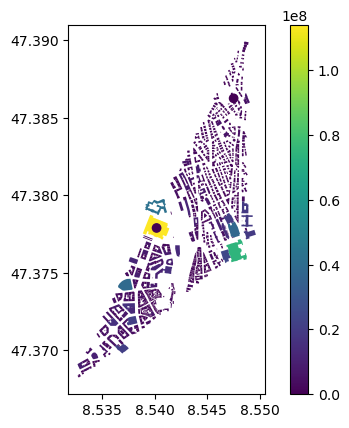

In [60]:
# Distribute building values based on building footprint area and total LitPop value for region
exp_buildings_zrh = distribute_lp_area(Exposures(gdf_zrh_buildings), val_zrh, mode='area')
exp_buildings_zrh.gdf.plot('value', legend=True)

**Example for cutting out "low-value" features from LitPop cells**

The idea behind this "reverse approach" to the one demonstrated before is to use OpenStreetMap info as a "stencil" for downscaling the coarser LitPop asset values (roughly 1x1km2), by defining low-value areas, and allocating all LitPop values to the _remaining_ area.

There are in turn several methods on how the allocation is done:
* equally spreading out the gridcell value on all the "valid" areas
* re-locating LitPop values based on nearest-neighbour centroids


"Low value features" in terms of asset values, i.e. natural areas, etc. can be found on OSM under the following keys and key-value pairs (not extensive list):
* 'natural',
* 'water', 
* 'waterway', 
* 'landuse=forest', 
* 'landuse=farmland',
* 'landuse=grass', 
* 'wetland'

In [39]:
# Load required packages:


In [ ]:
# One command does it all (getting LitPop Exp, re-assigning values, converting back into exposure format)


### 2.3: Performing impact calculations on OSM-based exposures

In [ ]:
# now perform a standard impact calc, specifying hazard and vulnerability curves ...

In [ ]:
# EITHER in 3 Steps interpolating exposures to Points, then impact calculation, then reaggregation
# OR: all in one go (interpolation, impact calc, re-aggregation ) using imp = u_lp.calc_geom_impact(...)